# Homework 2 - Vertical FL and Generative Modeling

Vertical federated learning (VFL) and generative modeling are two techniques for privacy preservation. The former enables collaborative training across vertically partitioned data. At the same time, the latter creates synthetic data as an alternative to using real sensitive data. In this assignment, you'll further explore some factors affecting model performance in VFL and how it can be bridged with generative modeling. 

# Instructions

Submit your assignment in ILIAS as only the Jupyter notebook with all relevant execution outputs and plots visible. Clearly indicate the relevant steps in your code, such as data preprocessing, model definition, training, etc. Partial grades can be given for incomplete problems provided the steps are clearly indicated.


## Exercise 1: Feature permutation in VFL (4 points)

Using the template code from [lab_vfl.ipynb](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/tutorial_2b/lab-vfl.ipynb), experiment with how shuffling the order of feature assignments to clients affects the performance. Use 4 clients with the default hyperparameters. Experiment with **3** random feature permutations and plot the training loss. Report whether/how shuffling features significantly affects the convergence rates and the reasoning behind it.

Scoring:
- _(1 point)_ Create 3 feature permutations with seeded Python/NumPy random functions and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ Describe what impact (if any) the permutations have on the loss and explain the observed pattern.

In [1]:
import random

import numpy as np
import torch

from matplotlib import pyplot as plt
from tqdm import tqdm 
import vfl

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
from components import preprocessing, partitions
from numpy import random as npr

features = preprocessing.feature_names

generator = npr.default_rng(seed=42)
for _ in range(3):
    permuted_features_idx = npr.permutation(len(features))
    permuted_features = [features[idx] for idx in permuted_features_idx]

    print(partitions.partition_elements_uniformly(permuted_features, 4))
    

[['restecg', 'ca', 'chol'], ['slope', 'cp', 'exang'], ['sex', 'thalach', 'oldpeak'], ['trestbps', 'age', 'fbs', 'thal']]
[['fbs', 'cp', 'trestbps'], ['chol', 'ca', 'age'], ['oldpeak', 'thal', 'thalach'], ['restecg', 'sex', 'slope', 'exang']]
[['slope', 'sex', 'restecg'], ['thalach', 'cp', 'thal'], ['fbs', 'ca', 'age'], ['trestbps', 'chol', 'oldpeak', 'exang']]


In [3]:
client_feature_name_mapping_variants = {
    "default": [
        ["age", "sex", "cp"],
        ["trestbps", "chol", "fbs"],
        ["restecg", "thalach", "exang"],
        ["oldpeak", "slope", "ca", "thal"],
    ],
    "columns permuted": [
        ["cp", "age", "sex"],
        ["fbs", "trestbps", "chol"],
        ["exang", "restecg", "thalach"],
        ["thal", "oldpeak", "slope", "ca"],
    ],
    "dissimilar": [
        ["age", "trestbps", "thalach"],
        ["sex", "chol", "exang"],
        ["restecg", "thal", "slope"],
        ["oldpeak", "ca", "fbs", "cp"],
    ],
    "random #1": [
        ["oldpeak", "sex", "fbs"],
        ["age", "slope", "thalach"],
        ["chol", "thal", "exang"],
        ["trestbps", "restecg", "ca", "cp"],
    ],
    "random #2": [
        ["age", "fbs", "cp"],
        ["restecg", "thal", "thalach"],
        ["chol", "slope", "ca"],
        ["oldpeak", "sex", "exang", "trestbps"],
    ],
    "random #3": [
        ["exang", "oldpeak", "fbs"],
        ["chol", "thal", "slope"],
        ["sex", "trestbps", "age"],
        ["cp", "thalach", "ca", "restecg"],
    ],
}

training_statistics, test_statistics = zip(
    *[
        vfl.run(client_feature_name_mapping=it)
        for it in tqdm(client_feature_name_mapping_variants.values(), "variant", leave=False)
    ]
)

training_statistics = list(training_statistics)
test_statistics = list(test_statistics)

(0.75, 0.9596224116930572)

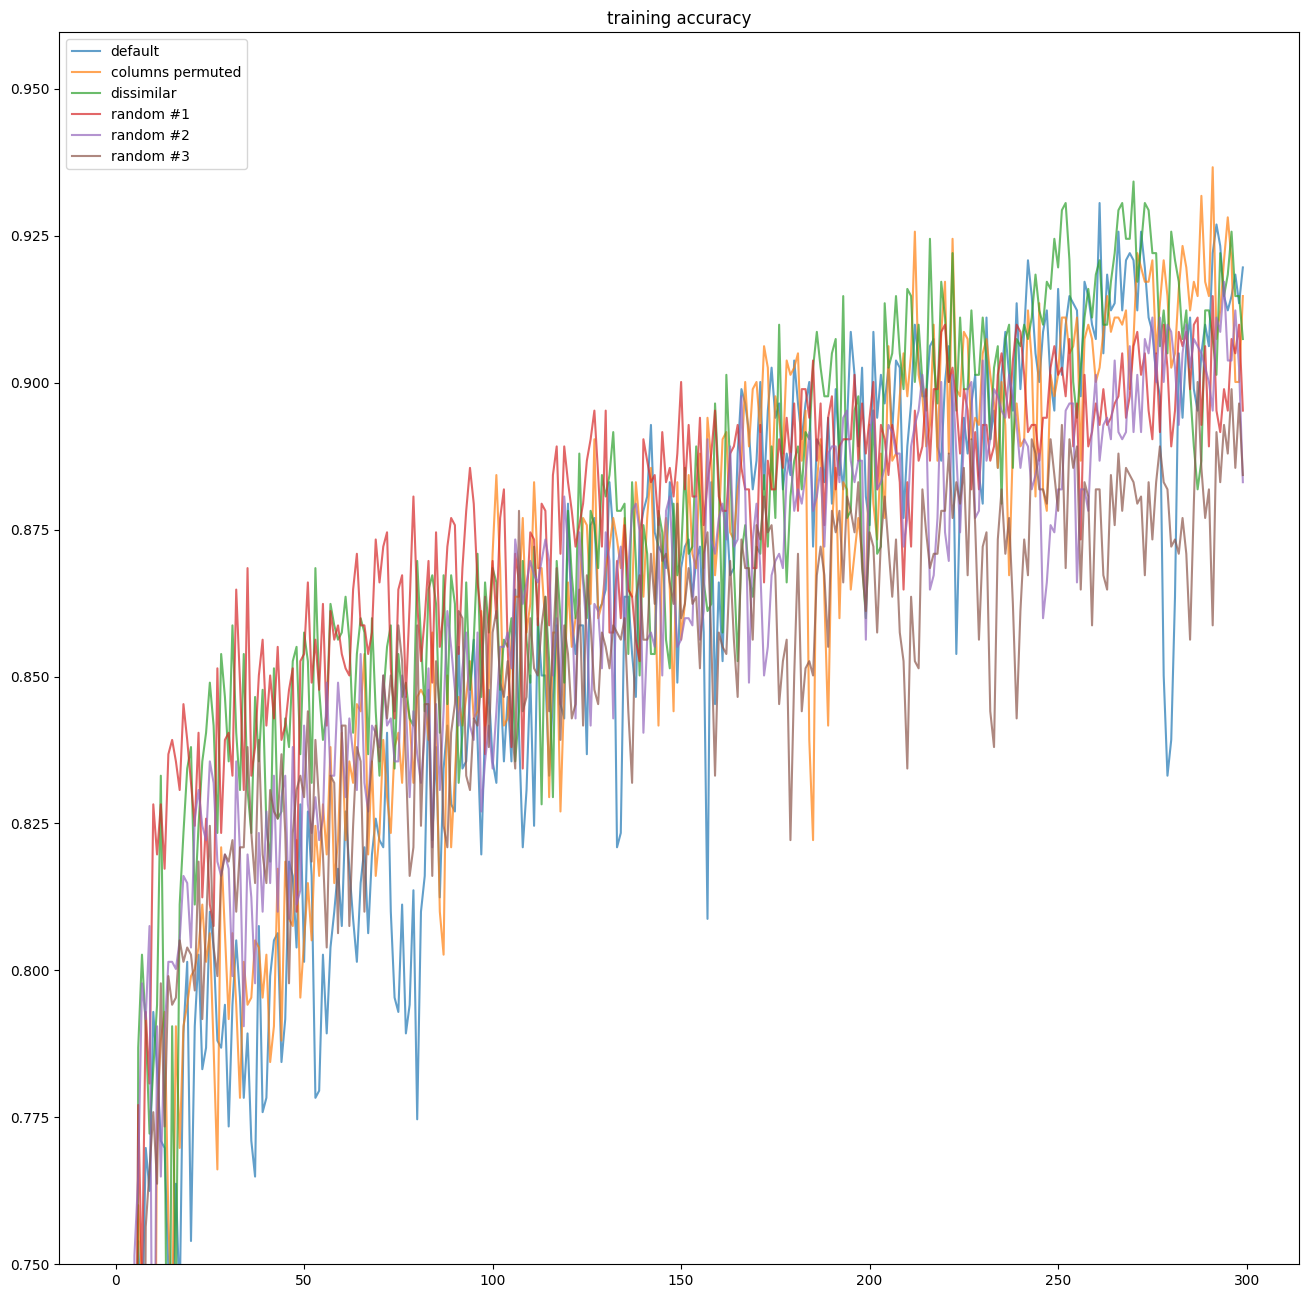

In [19]:
plt.figure(figsize=(16, 16))
plt.title("training accuracy")
for statistics, variant_name in zip(training_statistics, client_feature_name_mapping_variants.keys()):
    plt.plot(statistics.mean_epoch_accuracies, label=variant_name, alpha=0.7)
plt.legend()
plt.ylim(0.75, 0.95)

(0.17725095172914176, 0.5)

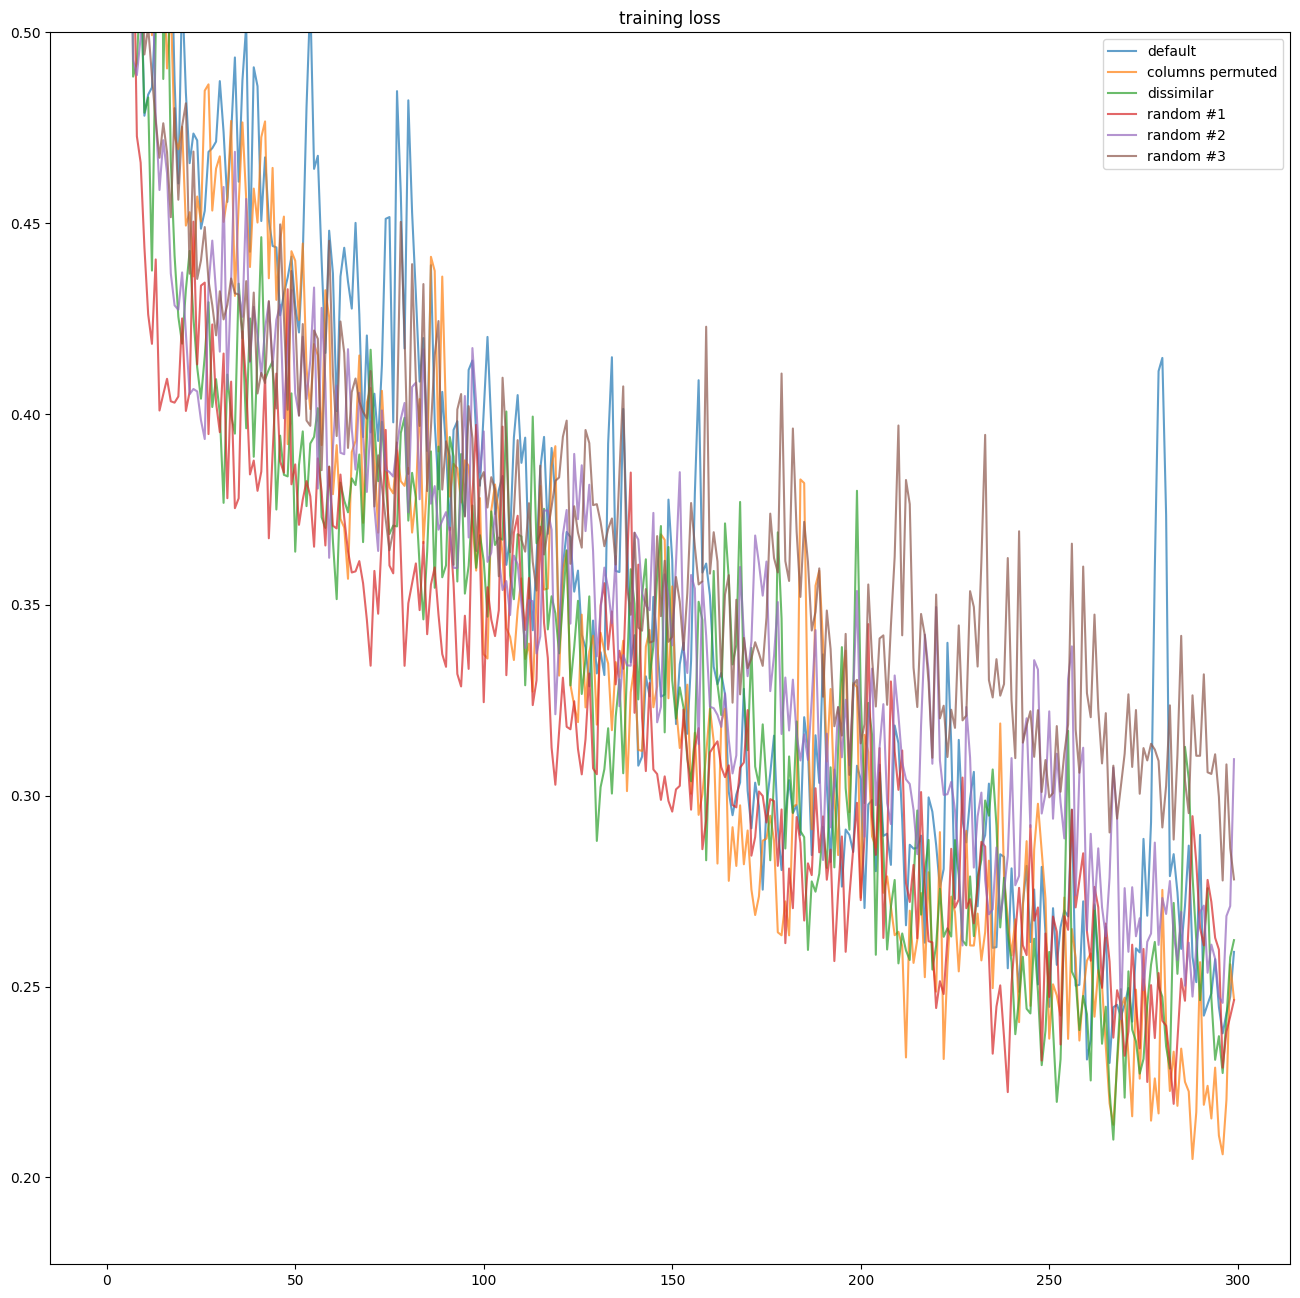

In [20]:
plt.figure(figsize=(16, 16))
plt.title("training loss")
for statistics, variant_name in zip(training_statistics, client_feature_name_mapping_variants.keys()):
    plt.plot(statistics.mean_epoch_losses, label=variant_name, alpha=0.7)
plt.legend()
plt.ylim(None, .5)

(0.75, 0.95)

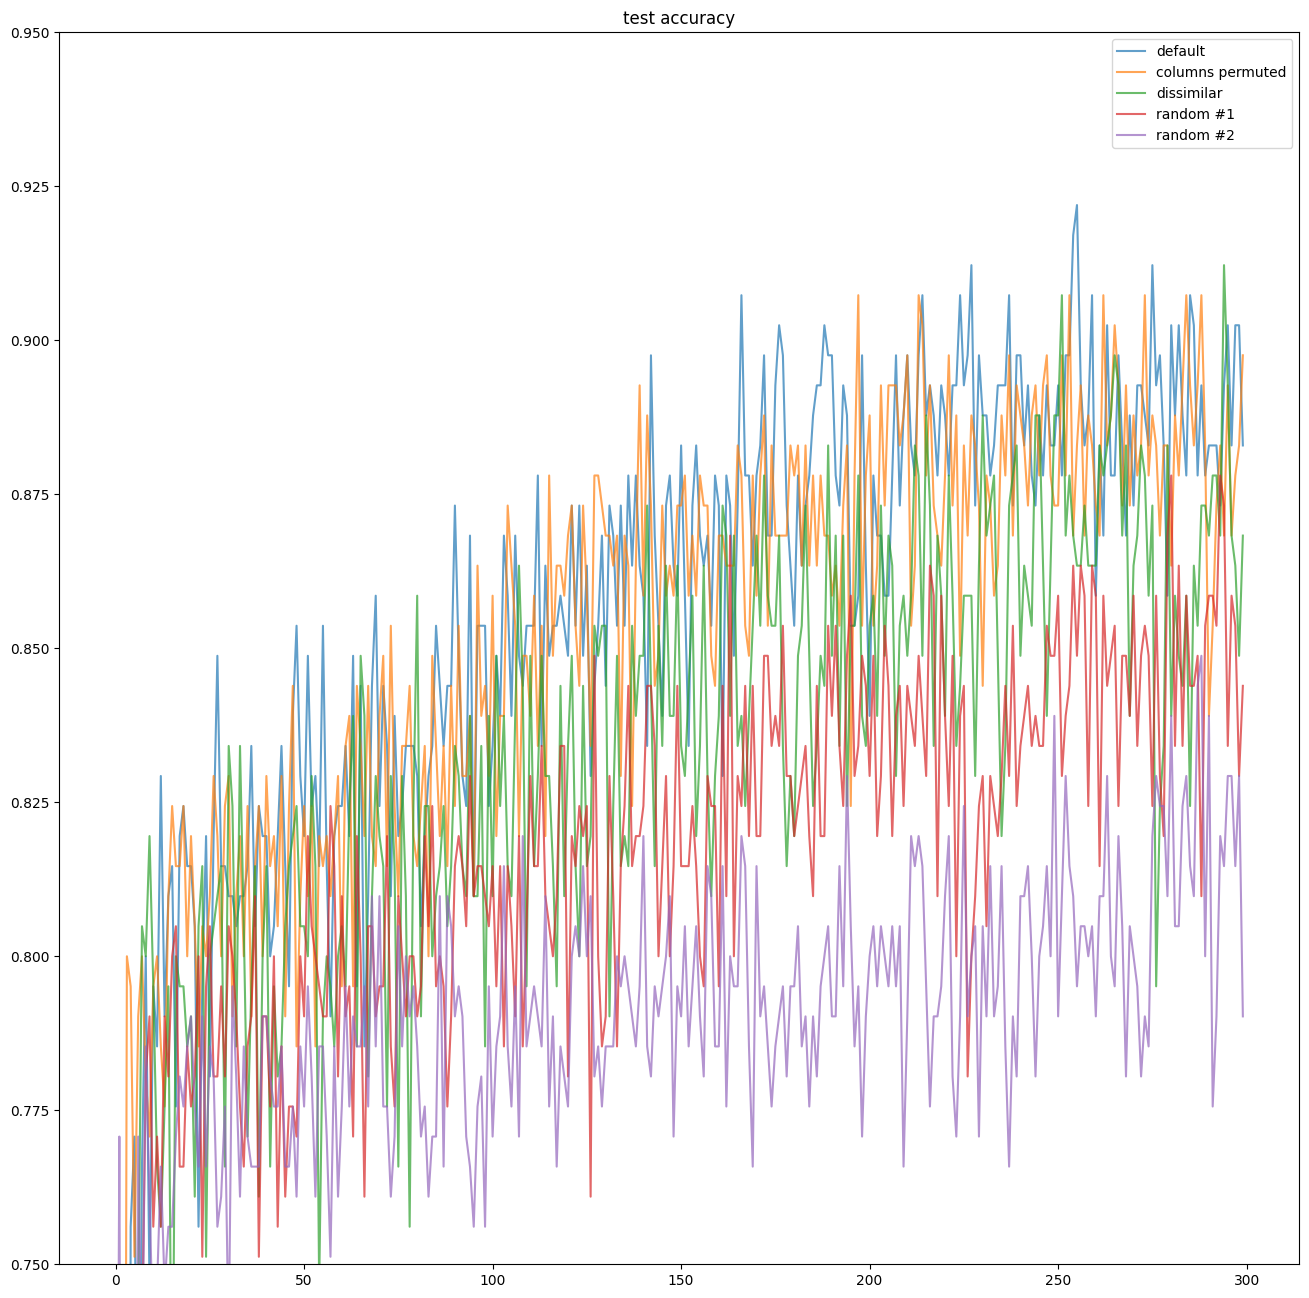

In [29]:
plt.figure(figsize=(16, 16))
plt.title("test accuracy")
for statistics, variant_name in zip(test_statistics, client_feature_name_mapping_variants.keys()):
    plt.plot(statistics.mean_epoch_accuracies, label=variant_name, alpha=0.7)
plt.legend()
plt.ylim(0.75, 0.95)

## Exercise 2: Scaling clients in VFL (5 points)

With the same template as above, experiment with how increasing the number of clients affects model performance. Explain the policy chosen for distributing features for different numbers of clients.

Scoring:
- _(1 point)_ Explain your scheme for partitioning the feature space under increasing number of clients.
- _(1 point)_ Implement the above explained partition mechanism for the requested client counts for the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) adding more clients has on the loss and explain the observed pattern.

In [21]:
client_variants = [1, 2, 4, 6, 8]

training_statistics, test_statistics = zip(
    *[
        vfl.run(clients=it)
        for it in tqdm(client_variants, "variant", leave=False)
    ]
)

training_statistics = list(training_statistics)
test_statistics = list(test_statistics)

(0.75, 0.976857490864799)

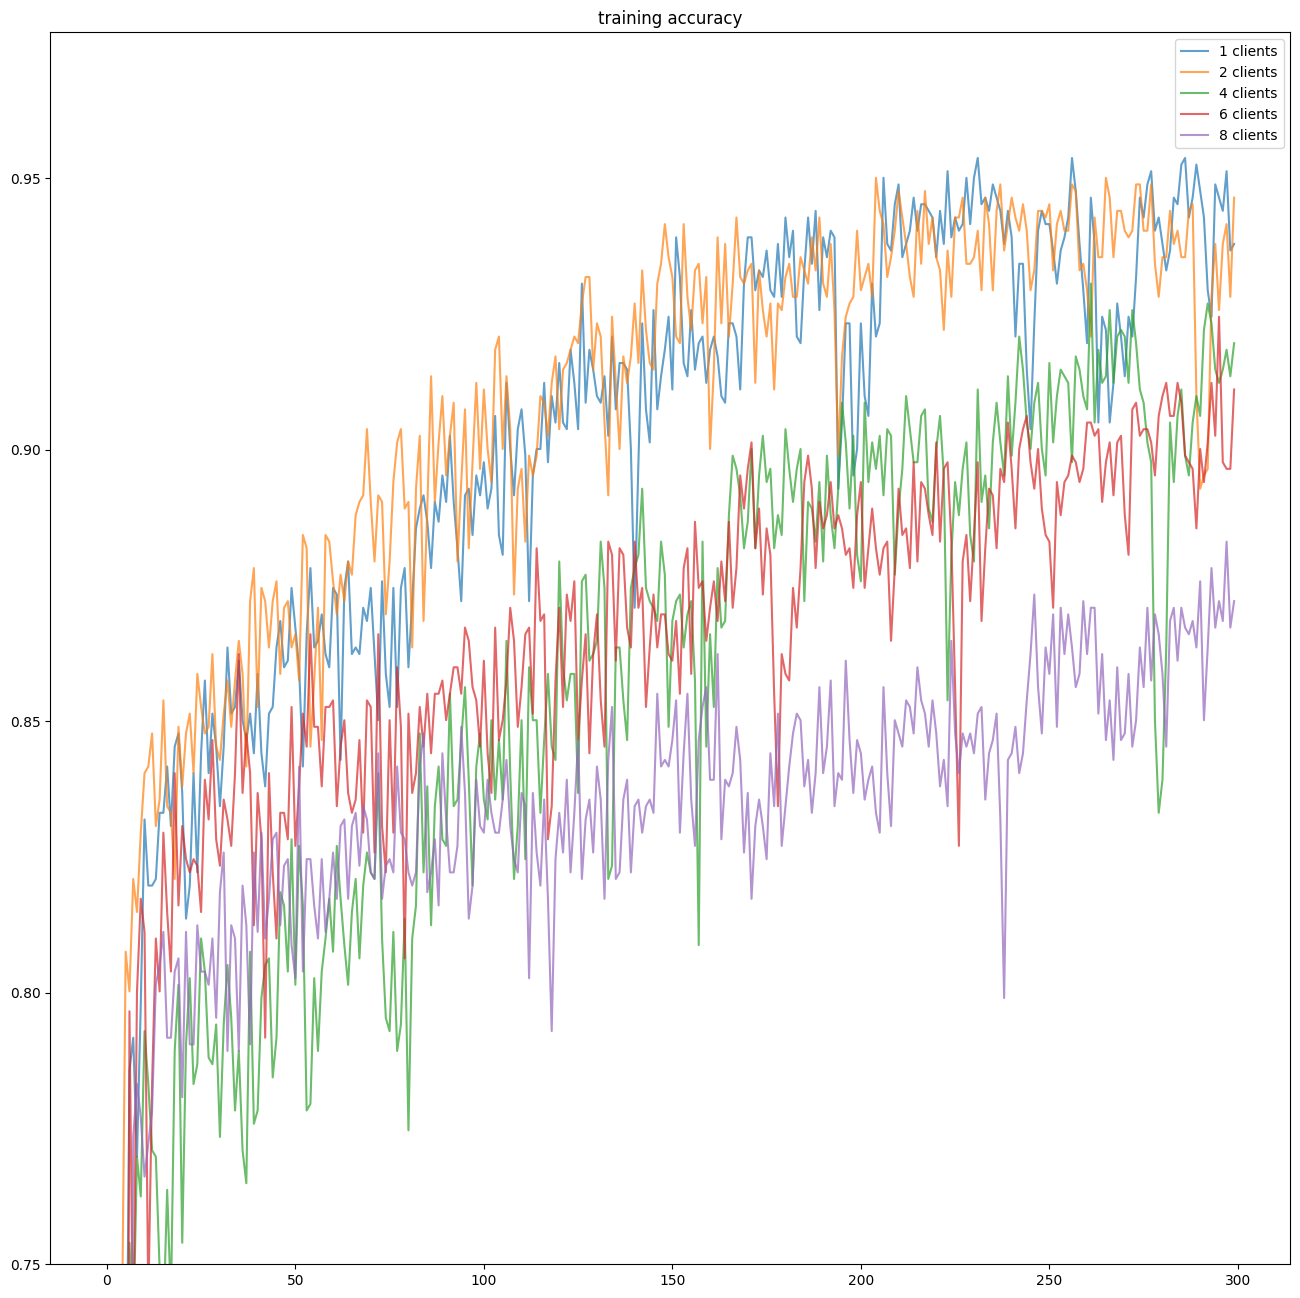

In [23]:
plt.figure(figsize=(16, 16))
plt.title("training accuracy")
for statistics, variant_name in zip(training_statistics, client_variants):
    plt.plot(statistics.mean_epoch_accuracies, label=f"{variant_name} clients", alpha=0.7)
plt.legend()
plt.ylim(0.75, 0.95)

(0.10961383976615391, 0.5)

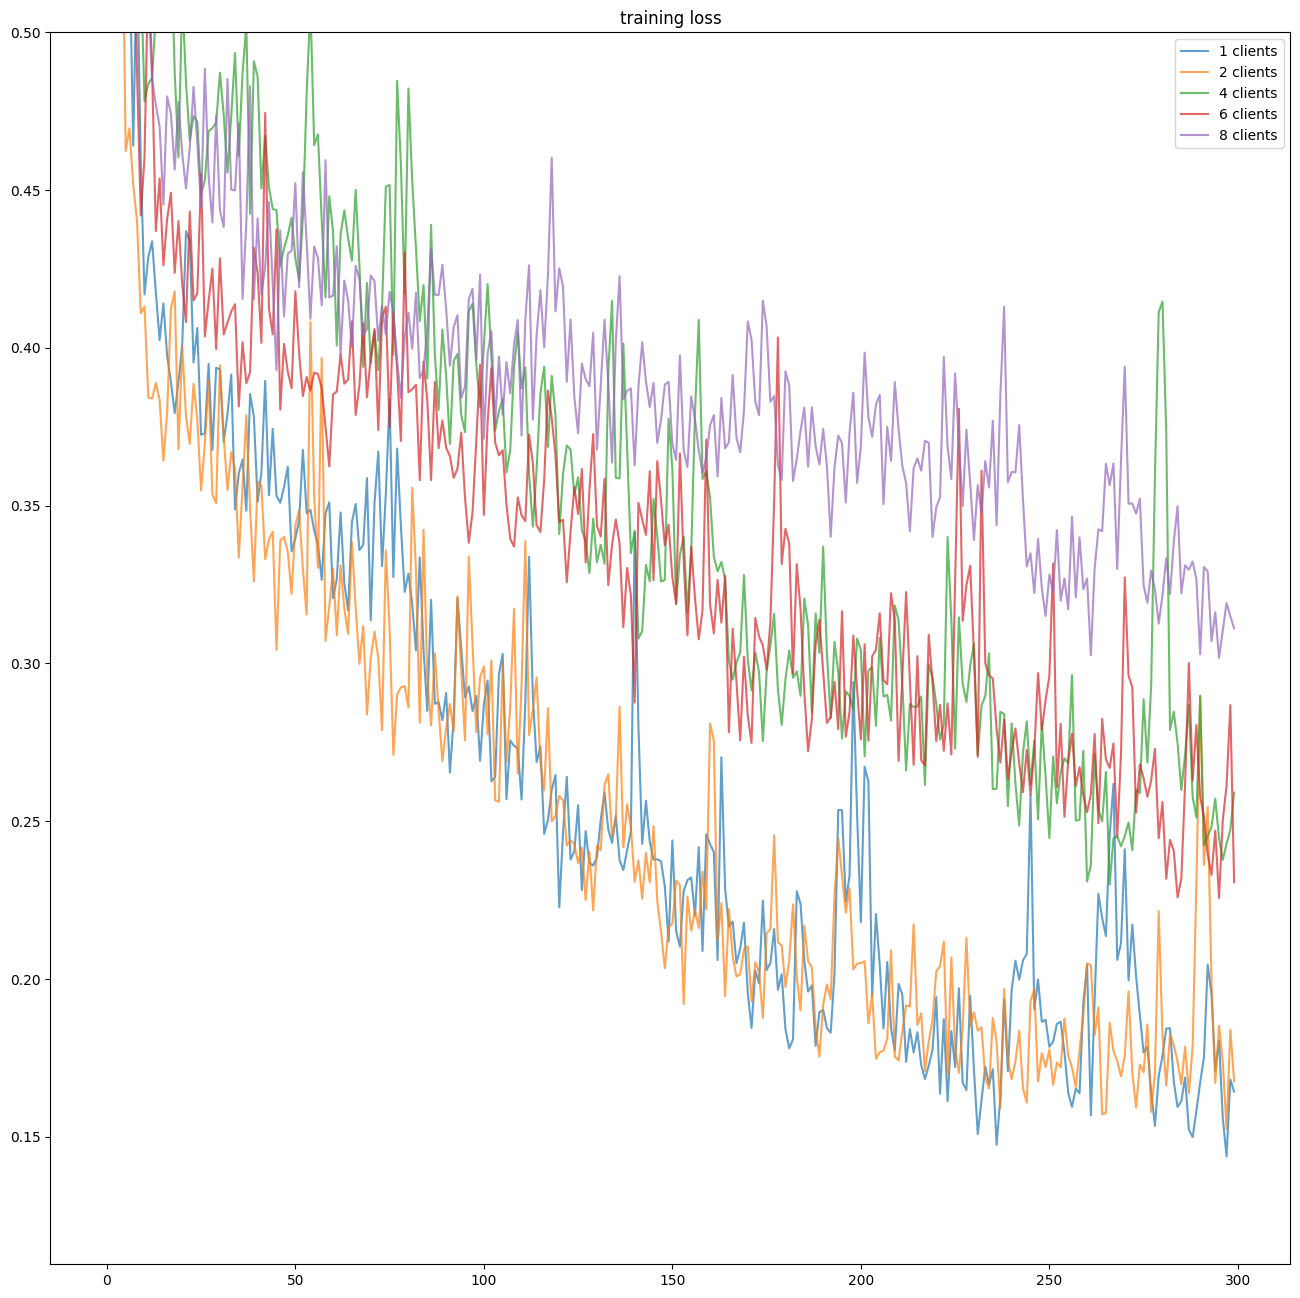

In [25]:
plt.figure(figsize=(16, 16))
plt.title("training loss")
for statistics, variant_name in zip(training_statistics, client_variants):
    plt.plot(statistics.mean_epoch_losses, label=f"{variant_name} clients", alpha=0.7)
plt.legend()
plt.ylim(None, .5)

(0.75, 0.95)

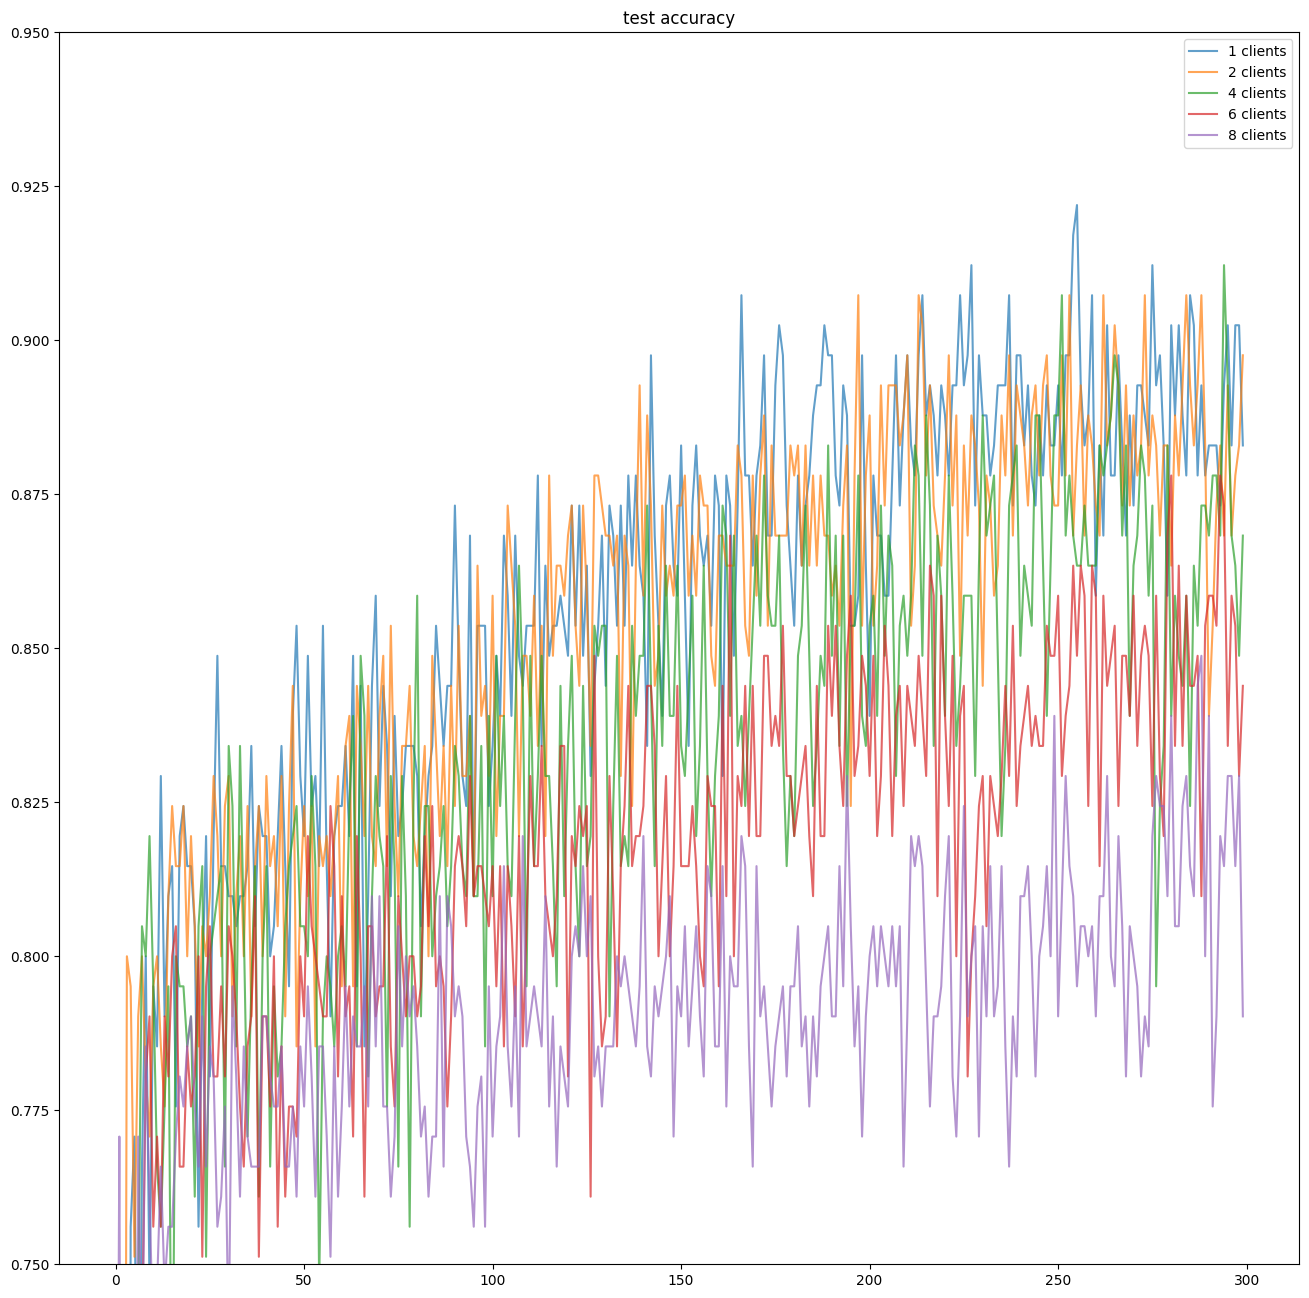

In [28]:
plt.figure(figsize=(16, 16))
plt.title("test accuracy")
for statistics, variant_name in zip(test_statistics, client_variants):
    plt.plot(statistics.mean_epoch_accuracies, label=f"{variant_name} clients", alpha=0.7)
plt.legend()
plt.ylim(0.75, 0.95)

## Exercise 3: Bridging VFL and generative modeling (10 points)

In this exercise, you'll explore how synthetic data can be generated when the data is constrained to be vertically partitioned. Combine VFL with variational autoencoders (VAEs) using the architecture described as follows. Each client uses a local encoder, i.e., a multi-layer perceptron (MLP) to embed its sensitive features into latents. These latents are concatenated at the server and passed through a VAE. The VAE produces synthetic latents which are partitioned and then converted back into the actual input space using another local MLP (decoder) at each client. Show the model's training progress per epoch. 

Scoring:
- _(1 point)_ Preprocess the dataset and partition the features.
- _(2 points)_ Define the encoder and decoder MLPs held by each client.
- _(2 points)_ Define the VAE used at the server over the concatenated feature representations from the clients.
- _(2 points)_ Define the VFL network that fits together the client networks and that of the server.
- _(1 point)_ Create and run the training loop of the complete model, including formulating the loss and printing it at every epoch.
- _(0.5 points)_ Consider, without implementing, an alternative scheme wherein the MLPs are first locally trained at the clients, followed by a separate training loop for the VAE at the server. How does this change what should be provided as input to the server?
- _(1.5 points)_ What are the pros and cons of the above mentioned alternative compared to the one implemented? Focus on the following aspects: privacy, communication costs, and performance.